In [1]:
import tqdm
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_cad = pd.read_csv("./processed_data/cadastro.csv")
df_medicoes = pd.read_csv("./processed_data/medicoes_texto_corrigido.csv")
df_qualificacao = pd.read_csv("./processed_data/qualificacao.csv")

df_cad_ = df_cad[df_cad['Latitude'] !=  '#N/D']

In [4]:
coords = df_cad_[['Latitude','Longitude']]
coords = coords[~coords["Latitude"].isna()]

idxx = coords.index
coords = coords.values

X_raw = coords.copy()


k_best = 8
kmeans = KMeans(n_clusters=k_best, random_state=42)
df_cad.loc[idxx, 'cluster_geo'] = kmeans.fit_predict(X_raw)

aux = df_cad[['Equipamento', 'Linha de Transmissão', 'Latitude', 'Longitude', 'Código ABC', 'Tensão', 'cluster_geo']]
df_docs = df_medicoes.merge(aux, on='Equipamento')

/home/andre/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [5]:
df_cad

,Equipamento,Linha de Transmissão,Denominação,Classe,Código ABC,Tensão,Latitude,Longitude,cluster_geo
0,115280,LT31,Torre 111,L_TORRE_AUTOPORT,C,230,-22.977610,-50.056523,3.0
1,115281,LT31,Torre 112,L_TORRE_AUTOPORT,C,230,-22.979172,-50.053168,3.0
2,115282,LT31,Torre 113,L_TORRE_AUTOPORT,C,230,-22.980874,-50.049499,3.0
3,115283,LT31,Torre 114,L_TORRE_AUTOPORT,C,230,-22.983017,-50.044919,3.0
4,115284,LT31,Torre 115,L_TORRE_AUTOPORT,C,230,-22.984675,-50.041349,3.0
...,...,...,...,...,...,...,...,...,...
36224,248914,LT4272,Torre 001A,L_TORRE_AUTOPORT,C,345,-23.659804,-46.724611,1.0
36225,248915,LT4272,Torre 002A,L_TORRE_AUTOPORT,C,345,-23.657644,-46.724533,1.0
36226,295034,LT4272,Torre 055,L_TORRE_AUTOPORT,C,345,-23.527798,-46.753380,1.0
36227,302615,LT4272,Torre 000-P,L_PORTICO,C,345,-23.659282,-46.724309,1.0


In [7]:
df_docs.to_csv("./processed_data/medicoes_texto_corrigido.csv", index=False)
df_cad.to_csv("./processed_data/cadastro_geo.csv", index=False)

In [4]:
# import folium
# import random
# from folium.plugins import MarkerCluster
# from branca.element import Figure


# fig = Figure(width=600, height=400)
# map_center = [df_cad['Latitude'].mean(), df_cad['Longitude'].mean()]
# m = folium.Map(location=map_center, zoom_start=6)

# import colorsys

# def distinct_hex_colors(n, saturation=0.65, value=0.95):
#     colors = []
#     for i in range(n):
#         h = i / n         
#         r, g, b = colorsys.hsv_to_rgb(h, saturation, value)
#         colors.append(
#             '#{:02x}{:02x}{:02x}'.format(
#                 int(r * 255), int(g * 255), int(b * 255)
#             )
#         )
#     return colors

# colors = distinct_hex_colors(19)

# # colors =  [f"#{random.randint(0, 0xFFFFFF):06x}" for i in range(19)]


# for idx, row in list(df_cad.iterrows())[:]:
#     try:
#         folium.CircleMarker(
#             location=(row['Latitude'], row['Longitude']),
#             radius=3,
#             color=colors[int(row['cluster_geo'])],
#             fill=True,
#             fill_color=colors[int(row['cluster_geo'])],
#             fill_opacity=0.7,
#             popup=f"Cluster: {row['cluster_geo']}"
#         ).add_to(m)
#     except:
#         ...


# fig.add_child(m)


In [5]:
df_cad.to_csv("./processed_data/cadastro_geo.csv", index=False)

In [6]:
medicoes = df_docs.groupby(['cluster_geo']).count()['Equipamento']/df_cad.groupby(['cluster_geo']).count()['Equipamento']
medicoes

cluster_geo
0.0     5.297699
1.0    13.805176
2.0     4.848000
3.0     5.166667
4.0     6.857178
5.0     3.837767
6.0     5.545842
7.0     6.303744
Name: Equipamento, dtype: float64

In [7]:
df_qualificado = df_docs[df_docs['Texto_classificado'] == 'Nota de Qualificação']
df_qualificado["Texto"] = df_qualificado["Texto"].astype(int)

/tmp/ipykernel_769704/89101610.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_qualificado["Texto"] = df_qualificado["Texto"].astype(int)


Text(0.5, 1.0, 'Relação entre medições por torres e cluster de geolocalização')

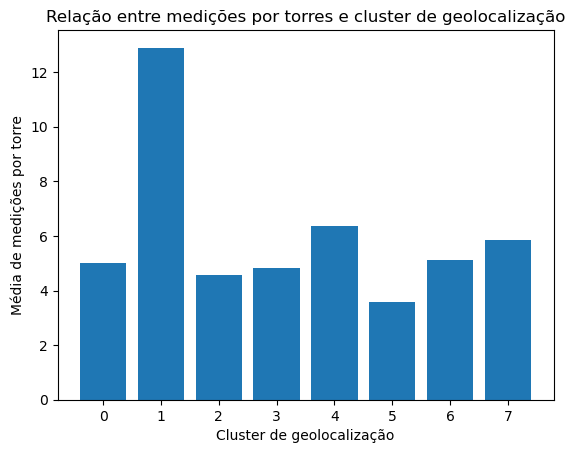

In [8]:
medicoes = df_qualificado.groupby(['cluster_geo']).count()['Equipamento']/df_cad.groupby(['cluster_geo']).count()['Equipamento']

plt.bar(x=medicoes.index, height=medicoes.values)
plt.xlabel("Cluster de geolocalização")
plt.ylabel("Média de medições por torre")
plt.title("Relação entre medições por torres e cluster de geolocalização")


In [9]:
counts = (
    df_qualificado
      .groupby(['cluster_geo','Denominação_categoria'])
      .size()
      .reset_index(name='counts')
)

idx = counts.groupby('cluster_geo')['counts'].idxmax()

max_per_cluster = counts.loc[idx].reset_index(drop=True)

print(max_per_cluster)

   cluster_geo Denominação_categoria  counts
0          0.0   Vegetação e Limpeza    9226
1          1.0              Corrosão   38254
2          2.0   Vegetação e Limpeza    6682
3          3.0   Vegetação e Limpeza    6104
4          4.0              Corrosão   10597
5          5.0   Vegetação e Limpeza    6094
6          6.0   Vegetação e Limpeza     685
7          7.0              Corrosão   12701


In [10]:
contagem_cat = (
    df_qualificado.groupby(['cluster_geo', 'Denominação_categoria'])['Texto']
      .count()
      .reset_index()
)

media_torre_por_cluster = (
    df_qualificado.groupby(['cluster_geo'])['Equipamento']
      .nunique()
      .reset_index()
)

# Calcular a média de ocorrências por torre em cada cluster e categoria
media_cat = pd.merge(contagem_cat, media_torre_por_cluster, on='cluster_geo')
media_cat['Texto'] = media_cat['Texto'] / media_cat['Equipamento']



media_cat.groupby('cluster_geo').apply(lambda g: g.nlargest(3, 'Texto'))


cluster_geo Denominação_categoria     Texto  Equipamento
cluster_geo                                                              
0.0         13           0.0   Vegetação e Limpeza  2.569201         3591
            3            0.0              Corrosão  1.435533         3591
            1            0.0       Base e Fundação  0.478140         3591
1.0         17           1.0              Corrosão  6.625216         5774
            28           1.0   Vegetação e Limpeza  2.379286         5774
            19           1.0            Distâncias  1.072220         5774
2.0         42           2.0   Vegetação e Limpeza  2.110550         3166
            32           2.0              Corrosão  1.793430         3166
            30           2.0       Base e Fundação  0.417562         3166
3.0         56           3.0   Vegetação e Limpeza  1.744997         3498
            46           3.0              Corrosão  1.656375         3498
            51           3.0                Outros  0.689823         3498
4.0         60           4.0              Corrosão  2.631487         4027
            70           4.0   Vegetação e Limpeza  1.836851         4027
            58           4.0       Base e Fundação  0.449714         4027
5.0         84           5.0   Vegetação e Limpeza  2.124085         2869
            74           5.0              Corrosão  1.350993         2869
            72           5.0       Base e Fundação  0.638550         2869
6.0         96           6.0   Vegetação e Limpeza  1.760925          389
            86           6.0       Base e Fundação  1.719794          389
            88           6.0              Corrosão  1.329049          389
7.0         100          7.0              Corrosão  2.407316         5276
            111          7.0   Vegetação e Limpeza  2.055914         5276
            98           7.0       Base e Fundação  0.470622         5276

In [11]:
aux_ = df_qualificado[df_qualificado['Texto'] != 5] 
aux_ = aux_[aux_['Texto'] != 9]

contagem_cat = (
    aux_.groupby(['cluster_geo', 'Denominação_categoria'])['Texto']
      .count()
      .reset_index()
)

media_torre_por_cluster = (
    df_qualificado.groupby(['cluster_geo'])['Equipamento'].nunique()
      .reset_index()
)

# Calcular a média de ocorrências por torre em cada cluster e categoria
media_cat = pd.merge(contagem_cat, media_torre_por_cluster, on='cluster_geo')
media_cat['Texto'] = media_cat['Texto'] / media_cat['Equipamento']



media_cat.groupby('cluster_geo').apply(lambda g: g.nlargest(3, 'Texto'))[['cluster_geo', 'Denominação_categoria', 'Texto']]
# media_cat

cluster_geo Denominação_categoria     Texto
cluster_geo                                                 
0.0         12           0.0   Vegetação e Limpeza  1.391813
            1            0.0       Base e Fundação  0.248399
            9            0.0                Outros  0.103592
1.0         27           1.0   Vegetação e Limpeza  1.462418
            16           1.0              Corrosão  0.544510
            18           1.0            Distâncias  0.518012
2.0         41           2.0   Vegetação e Limpeza  1.137081
            29           2.0       Base e Fundação  0.245736
            33           2.0            Distâncias  0.131712
3.0         54           3.0   Vegetação e Limpeza  0.789022
            43           3.0       Base e Fundação  0.173242
            50           3.0                Outros  0.108062
4.0         68           4.0   Vegetação e Limpeza  0.943134
            56           4.0       Base e Fundação  0.226720
            60           4.0            Distâncias  0.157934
5.0         80           5.0   Vegetação e Limpeza  1.234925
            70           5.0       Base e Fundação  0.349251
            72           5.0              Corrosão  0.055769
6.0         88           6.0   Vegetação e Limpeza  0.961440
            82           6.0       Base e Fundação  0.845758
            81           6.0    Acesso e Segurança  0.347044
7.0         103          7.0   Vegetação e Limpeza  1.091357
            90           7.0       Base e Fundação  0.224412
            94           7.0            Distâncias  0.043783

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

K = 3
counts = (
    df_qualificado
      .groupby(['cluster_geo', 'Denominação_categoria'])
      .size()
      .reset_index(name='counts')
)

# Get the number of unique equipments per cluster
equipamentos_por_cluster = (
    df_qualificado
      .groupby('cluster_geo')['Equipamento']
      .nunique()
      .reset_index(name='num_equipamentos')
)

# Merge with counts to normalize
counts = pd.merge(counts, equipamentos_por_cluster, on='cluster_geo')
counts['normalized_counts'] = counts['counts'] / counts['num_equipamentos']

topk = (
    counts
      .sort_values(['cluster_geo','normalized_counts'], ascending=[True, False])
      .groupby('cluster_geo')
      .head(K)
      .reset_index(drop=True)
)

pivot = topk.pivot(
    index='cluster_geo',
    columns='Denominação_categoria',
    values='normalized_counts'
).fillna(0)




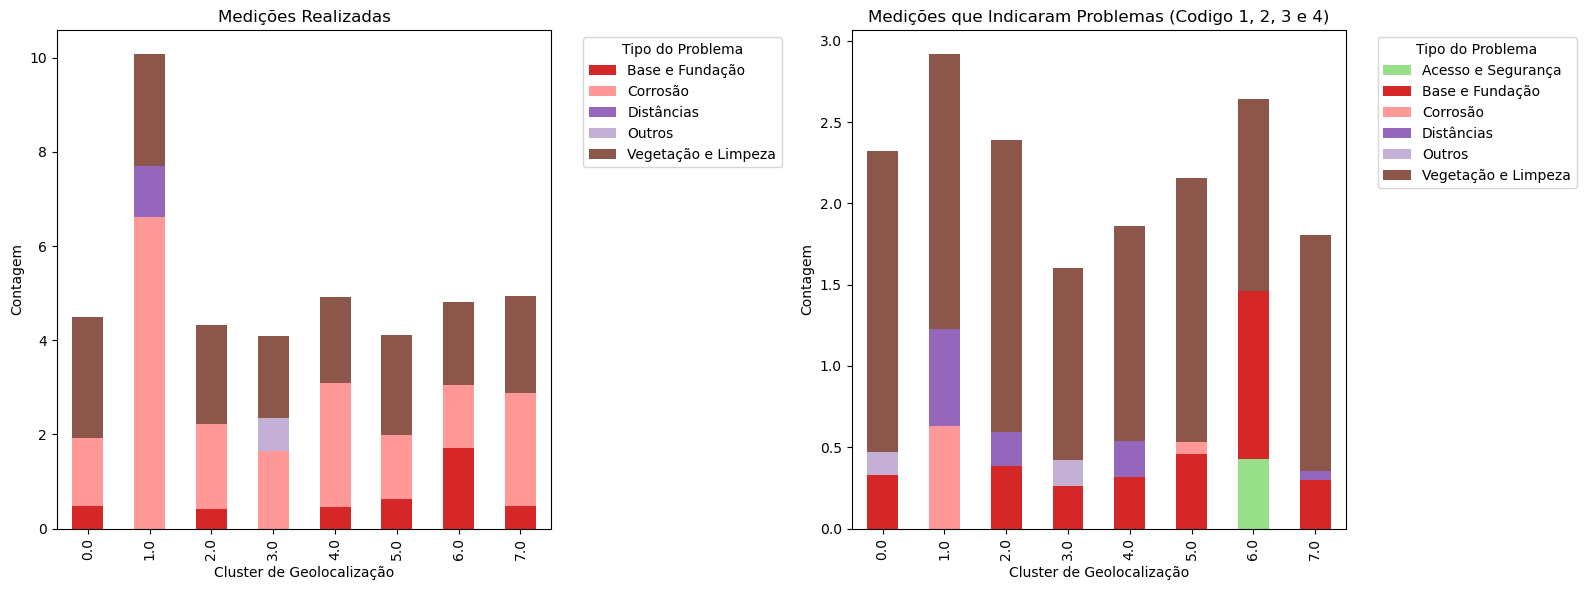

In [13]:
aux_problemas = df_qualificado[df_qualificado['Texto']!=(5)]
aux_problemas = aux_problemas[aux_problemas['Texto']!=(9)]


K = 3
counts2 = (
    aux_problemas
      .groupby(['cluster_geo', 'Denominação_categoria'])
      .size()
      .reset_index(name='counts')
)

# Get the number of unique equipments per cluster
equipamentos_por_cluster2 = (
    aux_problemas
      .groupby('cluster_geo')['Equipamento']
      .nunique()
      .reset_index(name='num_equipamentos')
)

# Merge with counts to normalize
counts2 = pd.merge(counts2, equipamentos_por_cluster2, on='cluster_geo')
counts2['normalized_counts'] = counts2['counts'] / counts2['num_equipamentos']

topk2 = (
    counts2
      .sort_values(['cluster_geo','normalized_counts'], ascending=[True, False])
      .groupby('cluster_geo')
      .head(K)
      .reset_index(drop=True)
)

pivot2 = topk2.pivot(
    index='cluster_geo',
    columns='Denominação_categoria',
    values='normalized_counts'
).fillna(0)


labels = list(pivot.columns)+list(pivot2.columns)

palette = dict(zip(
    labels,
    sns.color_palette("tab20", n_colors=len(labels))
))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), sharey=False)

pivot2.plot(
    kind='bar',
    ax=axes[1],
    color=[palette[col] for col in pivot2.columns], stacked=True,
)
axes[1].set_xlabel('Cluster de Geolocalização')
axes[1].set_ylabel('Contagem')
axes[1].set_title(f'Medições que Indicaram Problemas (Codigo 1, 2, 3 e 4)')
axes[1].legend(title='Tipo do Problema', bbox_to_anchor=(1.05, 1), loc='upper left')

pivot.plot(
    kind='bar',
    ax=axes[0],
    color=[palette[col] for col in pivot.columns], stacked=True,
)
axes[0].set_xlabel('Cluster de Geolocalização')
axes[0].set_ylabel('Contagem')
axes[0].set_title(f'Medições Realizadas')
axes[0].legend(title='Tipo do Problema', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [14]:
# .().columns

df_qualificado['flag_problema'] = df_qualificado['Texto'] < 5

resumo = (
    df_qualificado
    .groupby(['cluster_geo','Denominação_categoria'])
    .agg(total_inspecoes   = ('flag_problema','size'),
         n_problemas       = ('flag_problema','sum'))
    .reset_index()
)

/tmp/ipykernel_769704/627813192.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_qualificado['flag_problema'] = df_qualificado['Texto'] < 5


In [15]:
resumo['prop_risco_cluster'] = (resumo['n_problemas'] / resumo['total_inspecoes'])
resumo.to_csv("./processed_data/risco_cluster.csv", index=False)
resumo.head()

,cluster_geo,Denominação_categoria,total_inspecoes,n_problemas,prop_risco_cluster
0,0.0,Acesso e Segurança,146,85,0.582192
1,0.0,Base e Fundação,1717,892,0.519511
2,0.0,Componentes Estruturais,379,114,0.300792
3,0.0,Corrosão,5155,232,0.045005
4,0.0,Desgastes,38,3,0.078947
